### AttentionUNet with 2 channels

In [ ]:
# Update the notebook to incorporate any changes made in the environment
%load_ext autoreload
%autoreload 2

In [ ]:
 %reload_ext autoreload

In [2]:
# imports

# training and test modules import 
from src.test import test_loop
from src.train import train_loop
from src.eval import eval

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

# Unet
from monai.networks.nets import UNet

/tmp/ipykernel_15624/2988706584.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from src.load_XY import load_XY_2chanel


# Dataset import:
data_folder = "./data"

X, y = load_XY_2chanel(data_folder)

In [4]:
import random


# Assuming X and y are your data lists
# Combine X and y into a list of tuples
data = list(zip(X, y))

# Assuming each patient has 80 lists of tensors
lists_per_patient = 80

# Total number of patients
total_patients = len(data) // lists_per_patient

# Set the seed for reproducibility
random.seed(42)

# Shuffle the indices of patients
shuffled_patients = list(range(total_patients))
random.shuffle(shuffled_patients)

# Calculate the number of patients for each split
train_patients = 58
val_patients = 16
test_patients = 8

# Extract data for each split based on the shuffled indices
train_indices = shuffled_patients[:train_patients]
val_indices = shuffled_patients[train_patients: train_patients + val_patients]
test_indices = shuffled_patients[train_patients + val_patients: train_patients + val_patients + test_patients]

# Extract data for each split
train_data = [data[i * lists_per_patient: (i + 1) * lists_per_patient] for i in train_indices]
val_data = [data[i * lists_per_patient: (i + 1) * lists_per_patient] for i in val_indices]
test_data = [data[i * lists_per_patient: (i + 1) * lists_per_patient] for i in test_indices]

# Flatten the lists of lists into a single list for X and y
X_train, y_train = zip(*[item for sublist in train_data for item in sublist])
X_val, y_val = zip(*[item for sublist in val_data for item in sublist])
X_test, y_test = zip(*[item for sublist in test_data for item in sublist])

# Convert train, test and val into numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [5]:
# lenghts of train, test and val
print(f"Dimension of training set: {len(X_train), len(y_train)}\n")
print(f"Dimension of test set: {len(X_test), len(y_test)}\n")
print(f"Dimension of validation set: {len(X_val), len(y_val)}")

Dimension of training set: (4640, 4640)

Dimension of test set: (640, 640)

Dimension of validation set: (1280, 1280)


In [6]:
import torch

# Convert numpy array to tensors
X_train = torch.from_numpy(X_train).to(dtype=torch.float32)
X_val = torch.from_numpy(X_val).to(dtype=torch.float32)
X_test = torch.from_numpy(X_test).to(dtype=torch.float32)


# Match y dimension to the X
# y_train is a NumPy array
y_train = y_train[:, np.newaxis, :, :]
# Now, y_train has shape (4640, 1, 64, 64)

y_val = y_val[:, np.newaxis, :, :]
y_test = y_test[:, np.newaxis, :, :]

In [7]:
y_train.shape

(4640, 1, 64, 64)

In [8]:
# Custom Dataset

from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
# Creation of dataloaders

from torch.utils.data import DataLoader

train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size=32, shuffle=True)
validation_dataloader = DataLoader(CustomDataset(X_val, y_val), batch_size=32, shuffle=False)
test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size=32, shuffle=False)

In [10]:
from monai.networks.nets import AttentionUnet
from monai.utils import set_determinism
import torch


# Fixer la graine pour la reproductibilité
set_determinism(seed=42)

# Définir le modèle UNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  for spatial 2D
model = AttentionUnet(spatial_dims=2,
                          in_channels=2,
                          out_channels=1,
                          strides=(2,2,2,2),
                          channels=(64, 128, 256, 512, 1024)).to(device)
# print the architecture
print(model)

AttentionUnet(
  (model): Sequential(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Convolution(
          (conv): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (1): Convolution(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
      )
    )
    (1): AttentionLayer(
      (attention): AttentionBlock(
        (W_g): Sequential(
          (0): Convolution(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine

#### Training

In [13]:
# training and test modules import 
from src.test import test_loop
from src.train import train_loop
from src.eval import eval

from torch import nn

model_save_path = "./model/attention_Adam_MAE_100_2c_lr3.pth"
loss_fn = nn.L1Loss()
epochs = 100
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/100, loss: 0.2566
Epoch 1/100, loss: 0.0067
Validation loss: 0.0072

Epoch 2/100, loss: 0.0074
Epoch 2/100, loss: 0.0055
Validation loss: 0.0074

Epoch 3/100, loss: 0.0071
Epoch 3/100, loss: 0.0073
Validation loss: 0.0049

Epoch 4/100, loss: 0.0054
Epoch 4/100, loss: 0.0053
Validation loss: 0.0055

Epoch 5/100, loss: 0.0050
Epoch 5/100, loss: 0.0050
Validation loss: 0.0051

Epoch 6/100, loss: 0.0049
Epoch 6/100, loss: 0.0043
Validation loss: 0.0046

Epoch 7/100, loss: 0.0050
Epoch 7/100, loss: 0.0060
Validation loss: 0.0054

Epoch 8/100, loss: 0.0046
Epoch 8/100, loss: 0.0047
Validation loss: 0.0048

Epoch 9/100, loss: 0.0049
Epoch 9/100, loss: 0.0046
Validation loss: 0.0048

Epoch 10/100, loss: 0.0057
Epoch 10/100, loss: 0.0042
Validation loss: 0.0054

Epoch 11/100, loss: 0.0042
Epoch 11/100, loss: 0.0047
Validation loss: 0.0047

Epoch 12/100, loss: 0.0041
Epoch 12/100, loss: 0.0049
Validation loss: 0.0042

Epoch 13/100, loss: 0.0040
Epoch 13/100, loss: 0.0042
Validation loss:

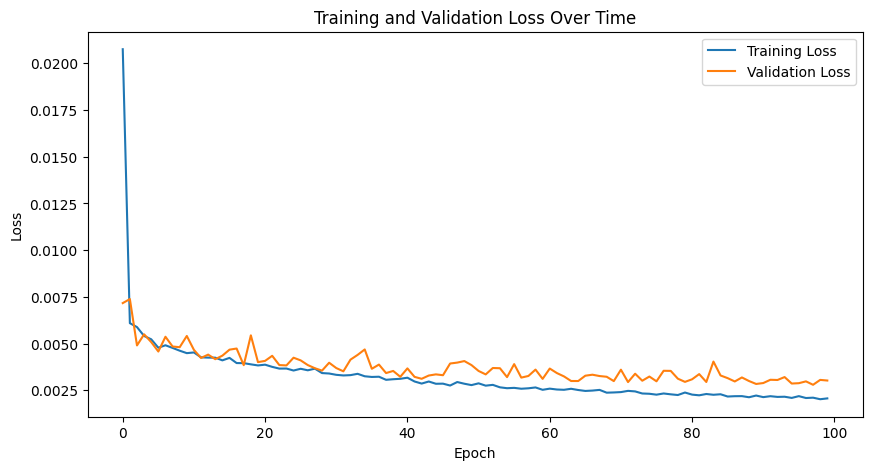




Test set: 
  PSNR: 41.1 dB, Avg loss: 0.002912
  Min PSNR: 36.5 dB, Max PSNR: 43.2 dB



In [14]:
torch.manual_seed(42)
eval(model, train_dataloader, validation_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, model_save_path)

### Prediction

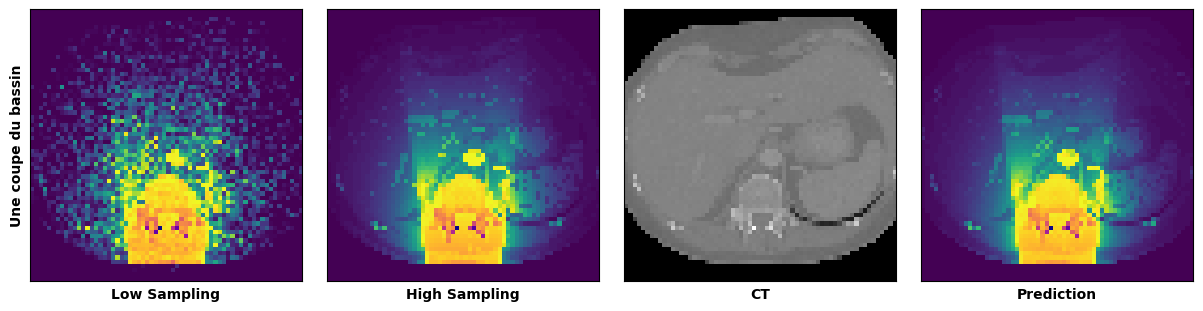

In [17]:
from src.predict import predict2
from src.visualization import visualize_prediction2c
import torch

# load the images for visualization
low = "./test/low_edep.mhd"
ct = "./test/ct.mhd"
ground_truth_data = "./test/high_edep.mhd"

# define paths for loading the features and saving the output visualization
paths = "./test/"
save_path = "./test/attention_Adam_MAE_100_2c_lr3.png"


# define path for model trained
model_path = './model/attention_Adam_MAE_100_2c_lr3.pth'
#load the model
model = torch.load(model_path)

# make prediction
predicted_data = predict2(model, paths, device=device)

# Visualisation
visualize_prediction2c(low, ground_truth_data, predicted_data, save_path, ct)